<a href="https://colab.research.google.com/github/Madushanka-Ranaweera/RNN-Sherlock-Holms/blob/main/RNN_Sherlock_Holms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the tensorflow notebook extension
%load_ext tensorboard

In [ ]:
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten

In [ ]:
datafile = r'/content/drive/MyDrive/Classroom/The Adventures of Sherlock Holmes.txt'

In [ ]:
text = open(datafile,'rb').read().decode(encoding='utf-8')
print('Book,, contains a total of {} characters'.format(len(text)))

Book,, contains a total of 593834 characters


In [ ]:
print(text[1500:1700])



I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of h


In [ ]:
# Removing the meta data text from out text file
text = text[1500:]

In [ ]:
# Counting unique characters (vocab size)
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

95 unique characters


In [ ]:
char2int = {u:i for i,u in enumerate(vocab)}
int2char = np.array(vocab)

text_as_int = np.array([char2int[c] for c in text])

In [ ]:
print("{")
for char,_ in zip(char2int,range(10)):
  print('{:4s} : {:3d},'.format(repr(char),char2int[char]))
print('...\n}')

{
'\n' :   0,
'\r' :   1,
' '  :   2,
'!'  :   3,
'"'  :   4,
'$'  :   5,
'%'  :   6,
'&'  :   7,
"'"  :   8,
'('  :   9,
...
}


In [ ]:
print('{} --- char-2-int --- {}'.format(repr(text[40:70]),text_as_int[40:70]))

' Sherlock Holmes she is always' --- char-2-int --- [ 2 47 63 60 73 67 70 58 66  2 36 70 67 68 60 74  2 74 63 60  2 64 74  2
 56 67 78 56 80 74]


In [ ]:
# The maximum length sentence we want for a single input in characters
seq_len = 100
examples_per_epoch = len(text)//(seq_len + 1)

# Create training examples / targets
char_data = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_data.take(20):
  print(int2char[i.numpy()])







I
.
 
A
 
S
C
A
N
D
A
L
 
I
N
 
B


In [ ]:
sequence = char_data.batch(seq_len + 1, drop_remainder=True)

for item in sequence.take(10):
  print(repr(''.join(int2char[item.numpy()])))
  print('_'*110)

'\n\r\nI. A SCANDAL IN BOHEMIA\r\n\r\n\r\nI.\r\n\r\nTo Sherlock Holmes she is always _the_ woman. I have seldom hea'
______________________________________________________________________________________________________________
'rd him\r\nmention her under any other name. In his eyes she eclipses and\r\npredominates the whole of her'
______________________________________________________________________________________________________________
' sex. It was not that he felt any emotion\r\nakin to love for Irene Adler. All emotions, and that one p'
______________________________________________________________________________________________________________
'articularly,\r\nwere abhorrent to his cold, precise but admirably balanced mind. He\r\nwas, I take it, th'
______________________________________________________________________________________________________________
'e most perfect reasoning and observing machine that\r\nthe world has seen, but as a lover he would have'
___________

In [ ]:
def split_input_target(chunk):


  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text,target_text

dataset = sequence.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print('Input data:',repr(''.join(int2char[input_example.numpy()])))
  print('Target data:',repr(''.join(int2char[target_example.numpy()])))

Input data: '\n\r\nI. A SCANDAL IN BOHEMIA\r\n\r\n\r\nI.\r\n\r\nTo Sherlock Holmes she is always _the_ woman. I have seldom he'
Target data: '\r\nI. A SCANDAL IN BOHEMIA\r\n\r\n\r\nI.\r\n\r\nTo Sherlock Holmes she is always _the_ woman. I have seldom hea'


In [ ]:
# Batch size
Batch_size = 64

# Buffer size to shuffle the dataset
Buffer_size = 10000

In [ ]:
dataset = dataset.shuffle(Buffer_size).batch(Batch_size,drop_remainder=True)
print("Dataset Shape = {}".format(dataset))

Dataset Shape = <BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


In [ ]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,
                                embedding_dim,
                                batch_input_shape=[batch_size,None]),
      tf.keras.layers.GRU(rnn_units,
                          return_sequences=True,
                          stateful=True,
                          recurrent_initializer='glorot_uniform'),
      tf.keras.layers.Dense(vocab_size)
    
  ])
  return model


In [ ]:
# Length of vocabulary in chars
vocab_size = len(vocab)

# The Embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=Batch_size
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           24320     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 95)            97375     
                                                                 
Total params: 4,059,999
Trainable params: 4,059,999
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def loss(labels,logits):
  return tf.keras.losses.sparse_categorical_crossentropy(label,logits,from_logits=True)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) )

In [ ]:
checkpoint_dir = r'data/training_checkpoint'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only = True)


In [ ]:
logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
history = model.fit(dataset,epochs=5,callbacks=[checkpoint_callback,tensorboard_callback])

Epoch 1/5
91/91 [==============================] - 474s 5s/step - loss: 2.9442
Epoch 2/5
91/91 [==============================] - 459s 5s/step - loss: 2.1955
Epoch 3/5
91/91 [==============================] - 458s 5s/step - loss: 1.9642
Epoch 4/5
91/91 [==============================] - 460s 5s/step - loss: 1.7841
Epoch 5/5
91/91 [==============================] - 463s 5s/step - loss: 1.6379


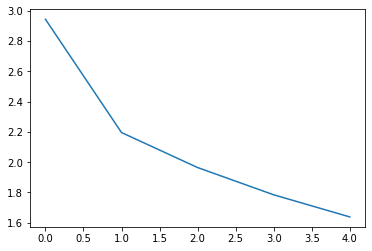

In [ ]:
import matplotlib.pyplot as plt

#graphs shows drop of loss function for our dataset
plt.plot(history.history['loss'])

In [ ]:
plt.plot(history.history['accuracy'])

KeyError: ignored